In [1]:
import pandas as pd
import numpy as np
import math
from time import time
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
from sklearn.preprocessing import StandardScaler
import regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

## Loading Superconductors dataset

In [2]:
df = pd.read_csv('superconductors.csv')

## Exploratory Data Analysis

Missing and categorical data

## Preprocessing

#### Creating data for traininig, validation and testing

In [5]:
X, y = df.iloc[:, :81].values, df.iloc[:, 81].values
# Holdout. Dividing dataset in two subsets: training and test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

## Regression Models

#### Simple Linear Regression

In [6]:
lr = LinearRegression()
t_0 = time()
lr.fit(X_train, y_train)
RT_lr = time()-t_0

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),
                                       mean_squared_error(y_test, y_test_pred)))
print('RMSE. train: %.3f, test: %.3f' % (math.sqrt(mean_squared_error(y_train, y_train_pred)),
                                       math.sqrt(mean_squared_error(y_test, y_test_pred))))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

MSE train: 306.076, test: 318.278
RMSE. train: 17.495, test: 17.840
R^2 train: 0.740, test: 0.726


k-fold Cross Validation

In [7]:
linr = LinearRegression()
kfold = KFold(n_splits=5).split(X_train, y_train)
scores = []
for k,(train, test) in enumerate(kfold):
    linr.fit(X_train[train], y_train[train])
    score = linr.score(X_train[test], y_train[test])
    scores.append(score)
    # print('Fold %2d '% (k+1),'scores:', score)
print(f'R^2 is {np.mean(scores)} +/- {np.std(scores)}')

R^2 is 0.7370948906648784 +/- 0.012516159115057327


Learning Curve

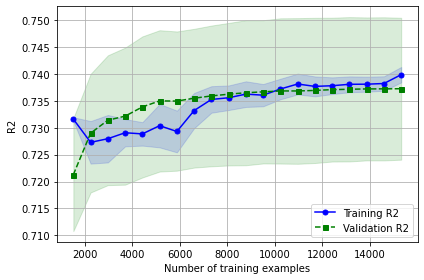

In [8]:
pipe_lr = make_pipeline(StandardScaler(), LinearRegression())
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 20),
                                                        cv=10, n_jobs=1, 
                                                        scoring = 'r2')

train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
test_mean, test_std  = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training R2')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
         label='Validation R2')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('R2')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

## Non Linear Regression

#### Decision Tree

In [9]:
tree = DecisionTreeRegressor(max_depth=11 )
t_0= time()
tree.fit(X_train, y_train)
RT_tree = time()-t_0

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
#print(ridge.coef_)
print('Ridge MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),
                                             mean_squared_error(y_test, y_test_pred)))
print('RMSE. train: %.3f, test: %.3f' % (math.sqrt(mean_squared_error(y_train, y_train_pred)),
                                       math.sqrt(mean_squared_error(y_test, y_test_pred))))
print('Ridge R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

Ridge MSE train: 88.149, test: 166.121
RMSE. train: 9.389, test: 12.889
Ridge R^2 train: 0.925, test: 0.857


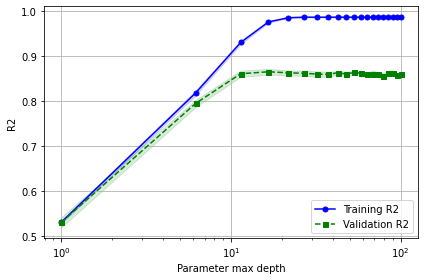

In [10]:
param_range = np.linspace(1, 100, 20)
train_scores, test_scores = validation_curve(estimator=DecisionTreeRegressor(), X=X_train, y=y_train,
                                             param_name='max_depth', param_range=param_range, cv=5,
                                            scoring='r2')

train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
test_mean, test_std  = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training R2')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='Validation R2')
plt.fill_between(param_range, test_mean + test_std,test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter max depth')
plt.ylabel('R2')
plt.tight_layout()
# plt.savefig('images/06_06.png', dpi=300)
plt.show()

#### Random Forest

In [11]:
forest = RandomForestRegressor(n_estimators=100, criterion='squared_error', random_state=1, n_jobs=-1)
t_0= time()
forest.fit(X_train, y_train)
RT_forest = time()-t_0
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),
                                       mean_squared_error(y_test, y_test_pred)))
print('RMSE. train: %.3f, test: %.3f' % (math.sqrt(mean_squared_error(y_train, y_train_pred)),
                                       math.sqrt(mean_squared_error(y_test, y_test_pred))))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

MSE train: 25.722, test: 90.035
RMSE. train: 5.072, test: 9.489
R^2 train: 0.978, test: 0.923


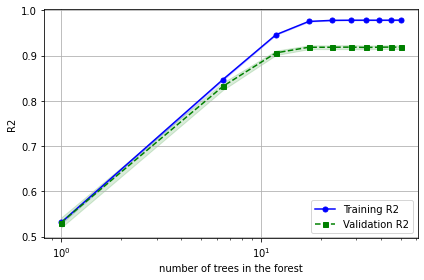

In [12]:
param_range = np.linspace(1, 50, 10)
train_scores, test_scores = validation_curve(estimator=RandomForestRegressor(), X=X_train, y=y_train,
                                             param_name='max_depth', param_range=param_range, cv=5,
                                            scoring='r2')

train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
test_mean, test_std  = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training R2')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='Validation R2')
plt.fill_between(param_range, test_mean + test_std,test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('number of trees in the forest')
plt.ylabel('R2')
plt.tight_layout()
# plt.savefig('images/06_06.png', dpi=300)
plt.show()

#### XGBoost Regressor

In [13]:
boost = XGBRegressor(n_estimators=374, eta = 0.02, max_depth = 16, subsample = 0.50)
t_0= time()
boost.fit(X_train, y_train)
RT_boost = time()-t_0
y_train_pred = boost.predict(X_train)
y_test_pred = boost.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),
                                       mean_squared_error(y_test, y_test_pred)))
print('RMSE. train: %.3f, test: %.3f' % (math.sqrt(mean_squared_error(y_train, y_train_pred)),
                                       math.sqrt(mean_squared_error(y_test, y_test_pred))))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))


MSE train: 20.318, test: 88.075
RMSE. train: 4.508, test: 9.385
R^2 train: 0.983, test: 0.924


In [14]:
param_grid = [{'n_estimators': [300, 374, 400], 'eta': [0.001, 0.02, 0.1], 'max_depth':[10, 16, 20],
               'subsample': [0.3, 0.5, 0.7]}]
gs = GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid, scoring='r2', refit=True, cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9230676377292486
{'eta': 0.02, 'max_depth': 16, 'n_estimators': 374, 'subsample': 0.5}


## Feature Selection

Using Random Forest

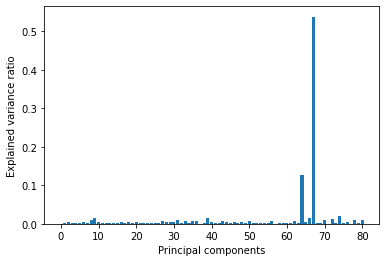

Index(['wtd_gmean_ElectronAffinity', 'wtd_std_atomic_mass',
       'wtd_range_ElectronAffinity', 'wtd_mean_atomic_mass', 'wtd_range_fie',
       'wtd_entropy_Density', 'range_atomic_radius', 'entropy_Density',
       'wtd_entropy_FusionHeat', 'wtd_mean_ThermalConductivity',
       'gmean_Density', 'wtd_std_ElectronAffinity', 'gmean_ElectronAffinity',
       'wtd_range_atomic_mass', 'wtd_std_ThermalConductivity',
       'wtd_std_Valence', 'wtd_range_Valence', 'mean_Density',
       'wtd_mean_Valence', 'std_Density', 'wtd_entropy_ThermalConductivity',
       'std_atomic_mass', 'wtd_gmean_Valence', 'wtd_gmean_ThermalConductivity',
       'range_ThermalConductivity'],
      dtype='object')


In [15]:
plt.bar(range(0, 81), forest.feature_importances_, alpha=1, align='center')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

best_features_ind = np.argsort(forest.feature_importances_)[-25:]
best_features = df.columns[best_features_ind]
print(best_features)
#sorted(forest.feature_importances_,reverse=True)

Using XGB

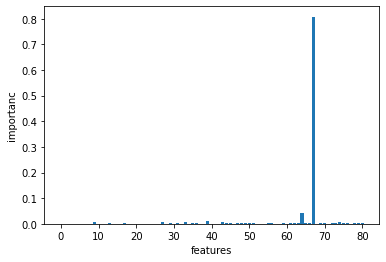

Index(['wtd_std_ThermalConductivity', 'range_fie', 'std_FusionHeat',
       'std_ThermalConductivity', 'entropy_Valence', 'wtd_std_Valence',
       'std_ElectronAffinity', 'entropy_FusionHeat', 'std_atomic_radius',
       'wtd_entropy_ThermalConductivity', 'wtd_std_ElectronAffinity',
       'wtd_range_Valence', 'entropy_ThermalConductivity', 'wtd_mean_Valence',
       'range_ElectronAffinity', 'entropy_Density', 'mean_Density',
       'gmean_ElectronAffinity', 'std_atomic_mass', 'gmean_Density',
       'range_atomic_radius', 'wtd_gmean_Valence', 'std_Density',
       'wtd_gmean_ThermalConductivity', 'range_ThermalConductivity'],
      dtype='object')


In [16]:
plt.bar(range(0, 81), boost.feature_importances_, alpha=1, align='center')

plt.ylabel('importanc')
plt.xlabel('features')
plt.show()
best_features_ind = np.argsort(boost.feature_importances_)[-25:]
best_features = df.columns[best_features_ind]
print(best_features)

## Running Time

In [17]:
print(RT_boost)

58.31195521354675
